In [5]:
import networkx as nx
import cenpy
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily

In [6]:
ct = "Connecticut, USA"
ct_NewH = ['New Haven County, Connecticut, USA']
ct_Mids = ['Middlesex County, Connecticut, USA']
ct_Tola = ['Tolland County, Connecticut, USA']
ct_Hart = ['Hartford County, Connecticut, USA']
ct_Fair = ['Fairfield County, Connecticut, USA']
          #{'city':'Los Altos Hills', 'state':'California'},
          #'Loyola, California']
        
desired_building_types = ['school', 'commercial', 'retail','office','garage','hotel','church','train_station','dormitory',
                          'mosque','warehouse','stadium','clubhouse','chapel','fire_station','university','kindergarten',
                         'service','construction','hospital','plant_nursery','greenhouse','public','government','farm_auxiliary',
                         'farm','boathouse','sports_centre','dome','hangar','kiosk','college','napa auto parts','cathedral',
                         'synagogue','library','museum','convent','store','yes;commercial','university;yes','supermarket','parish_hall',
                          'motel','roof;commercial']

municipal_building = ['school', 'office', 'fire_station','university','kindergarten','hospital','government','college','library','museum','university;yes']

In [7]:
def footprint_squarefeet(place_name, building_types):
    graph = ox.graph_from_place(place_name, network_type='all')
    area = ox.geocode_to_gdf(place_name)
    bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})

    building_geometries_series = gpd.GeoSeries(bldgs.geometry)
    total_footprint_area = building_geometries_series.area.sum()
    projected_crs = 'EPSG:6433'
    building_geometries_projected = bldgs.to_crs(projected_crs)
    total_footprint_area_projected = building_geometries_projected.area.sum()
    
    #print("Total Building Footprint Area:", total_footprint_area)
    #print("Total Building Footprint Area (Projected):", total_footprint_area_projected) #square feet
    return total_footprint_area_projected

In [8]:
ct_fs = footprint_squarefeet(ct, desired_building_types)
NewH_fs = footprint_squarefeet(ct_NewH, municipal_building)
Mids_fs = footprint_squarefeet(ct_Mids, municipal_building)
Tola_fs = footprint_squarefeet(ct_Tola, municipal_building)
Hart_fs = footprint_squarefeet(ct_Hart, municipal_building)
Fair_fs = footprint_squarefeet(ct_Fair, municipal_building)

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\4126494917.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\4126494917.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  total_footprint_area = building_geometries_series.area.sum()
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\4126494917.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function

In [10]:
footprint = pd.DataFrame({
        'County': ['New Haven','Hartford','Middlesex','Tolland','Fairfield','Statewide'],
        'Total Footprint Area (square feet)': [NewH,Hart,Mids,Tola,Fair,ct]
    })


footprint['Ratio'] = footprint['Total Footprint Area (square feet)']/ct

import pandas as pd
ct_emissions = pd.read_excel('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")
emi = ct_emissions.at[2,'2020 est']
footprint['GHG Emissions/MMTCO2e'] = footprint['Ratio']*emi
# Choose the rows you want to sum
rows_to_sum = [1, 2, 3]

# Calculate the sum of the selected rows
sum_result = footprint.iloc[rows_to_sum].sum()

newH_footprint = footprint.iloc[0]
Fair_footprint = footprint.iloc[4]
state_footprint = footprint.iloc[5]

# Choose two rows by label (index)
rows_to_extract = [0, 4,5]

# Extract the selected rows into a new DataFrame
footprint_msa = footprint.loc[rows_to_extract].copy()

# Remove the selected rows from the original DataFrame
#footprint_msa = footprint.drop(rows_to_extract)

position_to_add = 2

# Concatenate the DataFrame before and after the new row
footprint_msa = pd.concat([footprint_msa.iloc[:position_to_add], pd.DataFrame([sum_result]), footprint_msa.iloc[position_to_add:]]).reset_index(drop=True)

footprint_msa.loc[0, 'County'] = 'New Haven-Milford'
footprint_msa.loc[1, 'County'] = 'Bridgeport-Stamford-Norwalk'
footprint_msa.loc[2, 'County'] = 'Hartford-East Hartford-Middletown'

footprint_msa

,County,Total Footprint Area (square feet),Ratio,GHG Emissions/MMTCO2e
0,New Haven-Milford,1.624969e+06,0.101262,0.387276
1,Bridgeport-Stamford-Norwalk,1.509697e+06,0.094078,0.359804
2,Hartford-East Hartford-Middletown,2.712754e+06,0.169048,0.646526
3,Statewide,1.604720e+07,1.000000,3.824505


In [11]:
new_row = {
    'County': 'Rest of the state',
    'Total Footprint Area (square feet)': footprint_msa.iloc[3]['Total Footprint Area (square feet)'] - footprint_msa.iloc[:3]['Total Footprint Area (square feet)'].sum(),
    'Ratio': footprint_msa.iloc[3]['Ratio'] - footprint_msa.iloc[:3]['Ratio'].sum(),
    'GHG Emissions/MMTCO2e': footprint_msa.iloc[3]['GHG Emissions/MMTCO2e'] - footprint_msa.iloc[:3]['GHG Emissions/MMTCO2e'].sum()
}

footprint_msa = pd.concat([footprint_msa.iloc[:3], pd.DataFrame([new_row]), footprint_msa.iloc[3:]]).reset_index(drop=True)


msa = footprint_msa.iloc[0:3,0]
values = footprint_msa.iloc[0:3,-1]
Footprint_ratio = footprint_msa.iloc[0:4,2]
categories = footprint_msa.iloc[0:4,1]

footprint_msa 

,County,Total Footprint Area (square feet),Ratio,GHG Emissions/MMTCO2e
0,New Haven-Milford,1.624969e+06,0.101262,0.387276
1,Bridgeport-Stamford-Norwalk,1.509697e+06,0.094078,0.359804
2,Hartford-East Hartford-Middletown,2.712754e+06,0.169048,0.646526
3,Rest of the state,1.019978e+07,0.635611,2.430898
4,Statewide,1.604720e+07,1.000000,3.824505


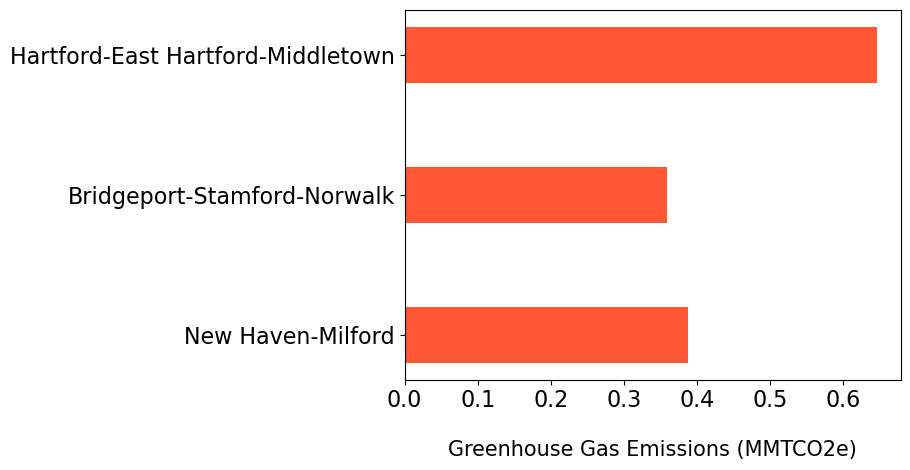

In [27]:
plt.barh(msa, values, 0.4, color="#FF5733")
plt.xlabel("Greenhouse Gas Emissions (MMTCO2e)",fontsize=15, labelpad=20)

plt.xticks(fontsize=16)  # Adjust the font size as needed
plt.yticks(fontsize=16)

#plt.show() 

plt.savefig('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/figures/municipal-building-emissions-osmnx.png', dpi=100,bbox_inches='tight')

In [22]:
def building_type_count(place_name, building_types):
    graph = ox.graph_from_place(place_name, network_type='all')
    area = ox.geocode_to_gdf(place_name)
    bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})

    # Use the correct variable name (bldgs) instead of bldgs_NewH
    unique_building_types = bldgs['building'].unique()

    # Use the correct variable name (bldgs) instead of bldgs_NewH
    building_type_counts = bldgs['building'].value_counts()

    # Iterate over the building types and counts
    for building_type, count in building_type_counts.items():
        print(f"{building_type}: {count} buildings")
        
    return building_type_counts

NewH = building_type_count(ct_NewH, municipal_building)
Mids = building_type_count(ct_Mids, municipal_building)
Tola = building_type_count(ct_Tola, municipal_building)
Hart = building_type_count(ct_Hart, municipal_building)
Fair = building_type_count(ct_Fair, municipal_building)




C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\909575037.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})


university: 313 buildings
school: 208 buildings
office: 23 buildings
hospital: 13 buildings
college: 7 buildings
government: 6 buildings
kindergarten: 5 buildings
library: 2 buildings
university;yes: 1 buildings


C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\909575037.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})


university: 53 buildings
school: 45 buildings
office: 37 buildings
hospital: 21 buildings
college: 21 buildings
government: 2 buildings
fire_station: 1 buildings


C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\909575037.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})


university: 74 buildings
school: 38 buildings
office: 10 buildings
government: 8 buildings
kindergarten: 2 buildings
hospital: 2 buildings


C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\909575037.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})


school: 282 buildings
office: 76 buildings
university: 64 buildings
hospital: 42 buildings
college: 32 buildings
kindergarten: 5 buildings
fire_station: 3 buildings
museum: 1 buildings


C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_3856\909575037.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bldgs = ox.geometries_from_place(place_name, tags={'building': building_types})


school: 201 buildings
office: 33 buildings
university: 22 buildings
hospital: 6 buildings
kindergarten: 6 buildings
fire_station: 3 buildings
college: 2 buildings
government: 2 buildings


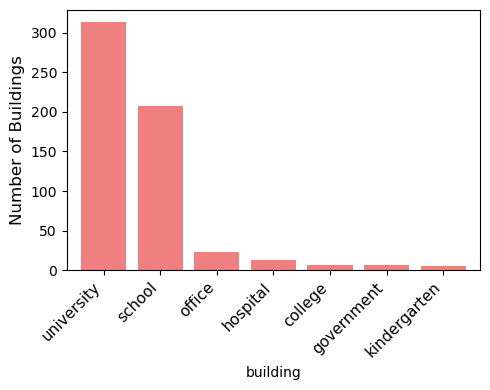

In [23]:
def plot_bar_chart(building_type_counts,color):
    #labels = building_type_counts.index[:7]
    #sizes = building_type_counts[labels].values

    plt.figure(figsize=(5, 4))
    building_type_counts.iloc[:7].plot(kind='bar', color=color,width=0.8)
    #plt.xlabel('Building Types')
    plt.ylabel('Number of Buildings',fontsize=12)
    #plt.title('Number of Buildings by Type')
    plt.xticks(rotation=45, ha='right',fontsize=11)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    #plt.show()
    
     


# Plot pie chart
plot_bar_chart(NewH,'lightcoral')
plt.savefig('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/figures/NewHaven-municipal-building-number.png', dpi=100,bbox_inches='tight')

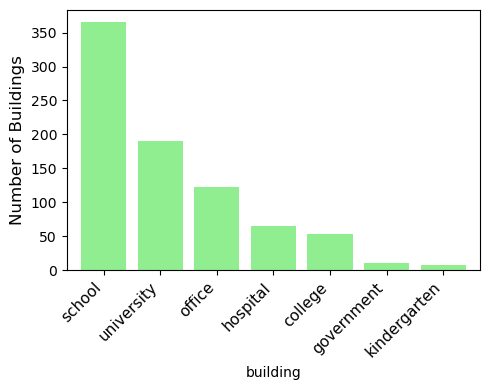

In [24]:
hartford_msa = pd.concat([Tola, Mids, Hart], axis=1).sum(axis=1)
hartford_msa = hartford_msa.sort_values(ascending=False)

plot_bar_chart(hartford_msa,'lightgreen')
plt.savefig('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/figures/Hartford-municipal-building-number.png', dpi=100,bbox_inches='tight')

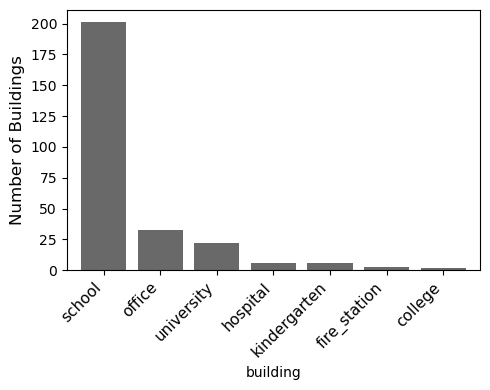

In [25]:
plot_bar_chart(Fair,'dimgray')
plt.savefig('C:/Users/peiyaozhao/Documents/GitHub/tracking-msa-ghg/figures/Fair-municipal-building-number.png', dpi=100,bbox_inches='tight')

commercial buidling total

New Haven-Milford	4.018928e+06	0.250444	0.957825
1	Bridgeport-Stamford-Norwalk	3.005132e+06	0.187268	0.716208
2	Hartford-East Hartford-Middletown	6.629864e+06	0.413148	1.580085
3	Statewide	1.604720e+07	1.000000	3.824505

In [29]:
#percentage of municipal building of all commercial building in each msa
NewHa = 1.624969e+06/4.018928e+06
Harte = 2.712754e+06/6.629864e+06
Fair = 1.509697e+06/3.005132e+06

In [30]:
NewHa

0.4043289653360299

In [31]:
Harte

0.4091718925154422

In [32]:
Fair

0.5023729406894606